### Fifa 22 Complete Player df_mainset [UPD:01/10/21]

##### Content

Replaced positions that do not exist in fifa, for example ["LS", "RS"] with "ST".
And a few more brief introductory notes:

- monetary values in Euro;
- height in cm;
- weight in kg;
- players without clubs in the Clubs column - "Free agent"
- players who are not include to national teams in the column "NationalTeam" - "Not in team"

---

##### Hypotesis
- **Hypothesis 1**: Players with higher potential ratings are typically younger and command a higher market value.
- **Hypothesis 2**: The overall rating of a player is strongly correlated with their market value and wage.

- **Question 1**: Which players have the highest growth potential and could represent high-value acquisitions for clubs looking to invest in future talent?
- **Question 2**: What are the key attributes that differentiate high-value players from lower-value players?
- **Question 3**: How does a player's physical attributes, such as height and weight, correlate with their overall and potential ratings?



In [154]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
df = pd.read_csv('players_fifa22.csv')

#### Checking what columns we have in the dataset

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19260 entries, 0 to 19259
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 19260 non-null  int64  
 1   Name               19260 non-null  object 
 2   FullName           19260 non-null  object 
 3   Age                19260 non-null  int64  
 4   Height             19260 non-null  int64  
 5   Weight             19260 non-null  int64  
 6   PhotoUrl           19260 non-null  object 
 7   Nationality        19260 non-null  object 
 8   Overall            19260 non-null  int64  
 9   Potential          19260 non-null  int64  
 10  Growth             19260 non-null  int64  
 11  TotalStats         19260 non-null  int64  
 12  BaseStats          19260 non-null  int64  
 13  Positions          19260 non-null  object 
 14  BestPosition       19260 non-null  object 
 15  Club               19260 non-null  object 
 16  ValueEUR           192

In [157]:

# 3df.iloc[:, 30:]
df.describe()

,ID,Age,Height,Weight,Overall,Potential,Growth,TotalStats,BaseStats,ValueEUR,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
count,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,1.926000e+04,...,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000,19260.000000
mean,231682.741952,25.184683,181.305036,74.950779,65.815628,71.100104,5.284476,1598.525909,357.062461,2.857652e+06,...,58.364434,57.227207,58.364434,56.197040,55.771340,56.197040,55.539823,54.379595,55.539823,23.242939
std,26960.272515,4.737340,6.866151,7.066864,6.817297,6.092103,5.472201,271.575855,39.910613,7.604532e+06,...,13.989045,13.212152,13.989045,13.818416,13.856922,13.818416,14.063862,14.678658,14.063862,15.053823
min,41.000000,16.000000,155.000000,49.000000,48.000000,49.000000,0.000000,767.000000,227.000000,0.000000e+00,...,17.000000,17.000000,17.000000,17.000000,18.000000,17.000000,16.000000,18.000000,16.000000,10.000000
25%,214903.500000,21.000000,176.000000,70.000000,62.000000,67.000000,0.000000,1462.000000,329.000000,4.750000e+05,...,54.000000,52.000000,54.000000,51.000000,48.000000,51.000000,49.000000,44.000000,49.000000,17.000000
50%,236687.500000,25.000000,181.000000,75.000000,66.000000,71.000000,4.000000,1633.000000,358.000000,9.750000e+05,...,62.000000,60.000000,62.000000,59.000000,59.000000,59.000000,59.000000,58.000000,59.000000,18.000000
75%,253607.500000,29.000000,186.000000,80.000000,70.000000,75.000000,9.000000,1782.000000,384.000000,2.000000e+06,...,67.000000,66.000000,67.000000,65.000000,66.000000,65.000000,65.000000,66.000000,65.000000,20.000000
max,264705.000000,54.000000,206.000000,110.000000,93.000000,95.000000,26.000000,2341.000000,501.000000,1.940000e+08,...,93.000000,91.000000,93.000000,88.000000,90.000000,88.000000,88.000000,89.000000,88.000000,92.000000


#### Checking missing values

In [158]:
df.isna().sum().sort_values(ascending=False)

NationalNumber       18503
NationalPosition     18503
ClubNumber              76
ContractUntil           76
ClubPosition            76
                     ...  
DefensiveWorkRate        0
AttackingWorkRate        0
SkillMoves               0
WeakFoot                 0
GKRating                 0
Length: 90, dtype: int64

#### Selecting relevant columns
- Since this dataset consists of 90 columns so I will exclude all the columns I think are irrelevant for my hypotheses.
##### Column meanings
- I've never played FIFA so im going to guess what these stats mean.
    - `Overall` = Final evaluation of players skills.
    - `Potential` = Players potential
    - `Growth` = Difference between Potential and Overall
    - `TotalStats` = Maximum skills the player can achieve.
    - `BaseStats` = Skills the player starts with.
    - `WeakFoot` = Every player has prefered foot, this value ranges from 1 to 5 and represents how good is the player when not using prefered foot (higher = better).
    - `SkillMoves` = Determines how many tricks the player can pull off (creativity during play?).

In [ ]:
df_main = df.copy()
df_main = df_main.loc[:, ['Age', 'Height', 'Weight', 'Overall', 'Potential', 'Growth', 'TotalStats', 'BaseStats', 'ValueEUR', 'WageEUR', 'WeakFoot', 'SkillMoves', 'PaceTotal', 'ShootingTotal', 'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal']]
df_main.isna().sum().sort_values(ascending=False)

Age                 0
Height              0
DefendingTotal      0
DribblingTotal      0
PassingTotal        0
ShootingTotal       0
PaceTotal           0
SkillMoves          0
WeakFoot            0
WageEUR             0
ValueEUR            0
BaseStats           0
TotalStats          0
Growth              0
Potential           0
Overall             0
Weight              0
PhysicalityTotal    0
dtype: int64

##### 

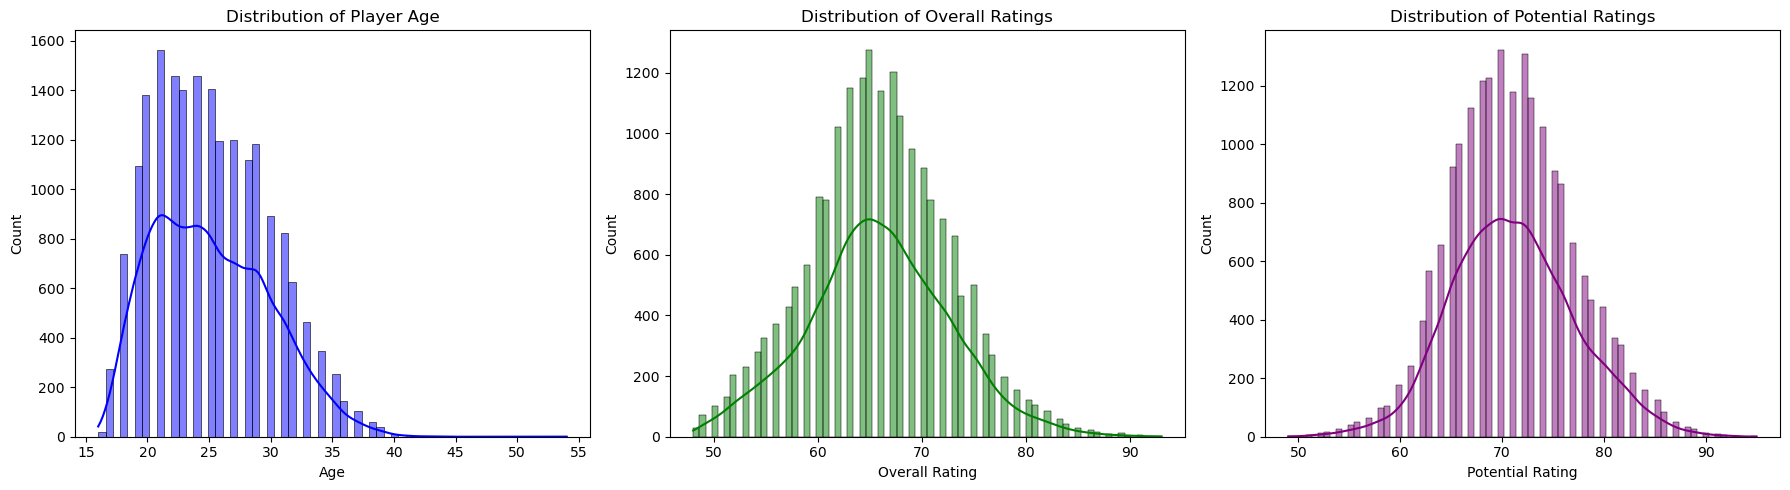

In [160]:

# Plot distribution of Age, Overall, and Potential
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_main['Age'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Player Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

sns.histplot(df_main['Overall'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Overall Ratings')
axes[1].set_xlabel('Overall Rating')

sns.histplot(df_main['Potential'], kde=True, ax=axes[2], color='purple')
axes[2].set_title('Distribution of Potential Ratings')
axes[2].set_xlabel('Potential Rating')

plt.tight_layout()
plt.show()


####  Which players have the highest growth potential and could represent high-value acquisitions for clubs looking to invest in future talent?

In [ ]:
# # select all numerical columns
# df_num = df.select_dtypes(include=[np.number])
# corr_num = df_num.corr()
# plt.figure(figsize=(50, 50))
# sns.heatmap(corr_num, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Correlation Matrix of FIFA Player Attributes')
# plt.show()

# which players have the highest growth potential


,Age,Height,Weight,Overall,Potential,Growth,TotalStats,BaseStats,ValueEUR,WageEUR,WeakFoot,SkillMoves,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal
18993,17,191,77,51,77,26,813,286,220000,500,2,1,58,50,52,49,28,49
16929,17,185,80,58,84,26,919,312,0,0,1,1,55,57,58,63,21,58
15915,17,185,69,60,85,25,1583,344,775000,500,3,3,72,51,57,68,38,58
17194,16,180,70,57,82,25,1579,329,500000,1000,3,2,64,46,56,59,51,53
19166,17,165,63,49,74,25,1389,291,150000,500,4,3,69,45,44,50,36,47
19254,17,195,95,48,73,25,811,270,130000,500,2,1,51,45,59,53,20,42
18626,16,178,58,53,78,25,1386,288,300000,550,3,3,59,50,49,58,32,40
18508,17,181,68,53,78,25,1472,320,275000,500,3,3,69,42,53,60,44,52
19065,17,192,73,50,74,24,1164,239,140000,500,2,2,55,25,30,29,53,47
19215,17,188,72,49,73,24,1165,250,140000,500,2,2,61,21,35,34,49,50


#### Let's take a look at column corelations

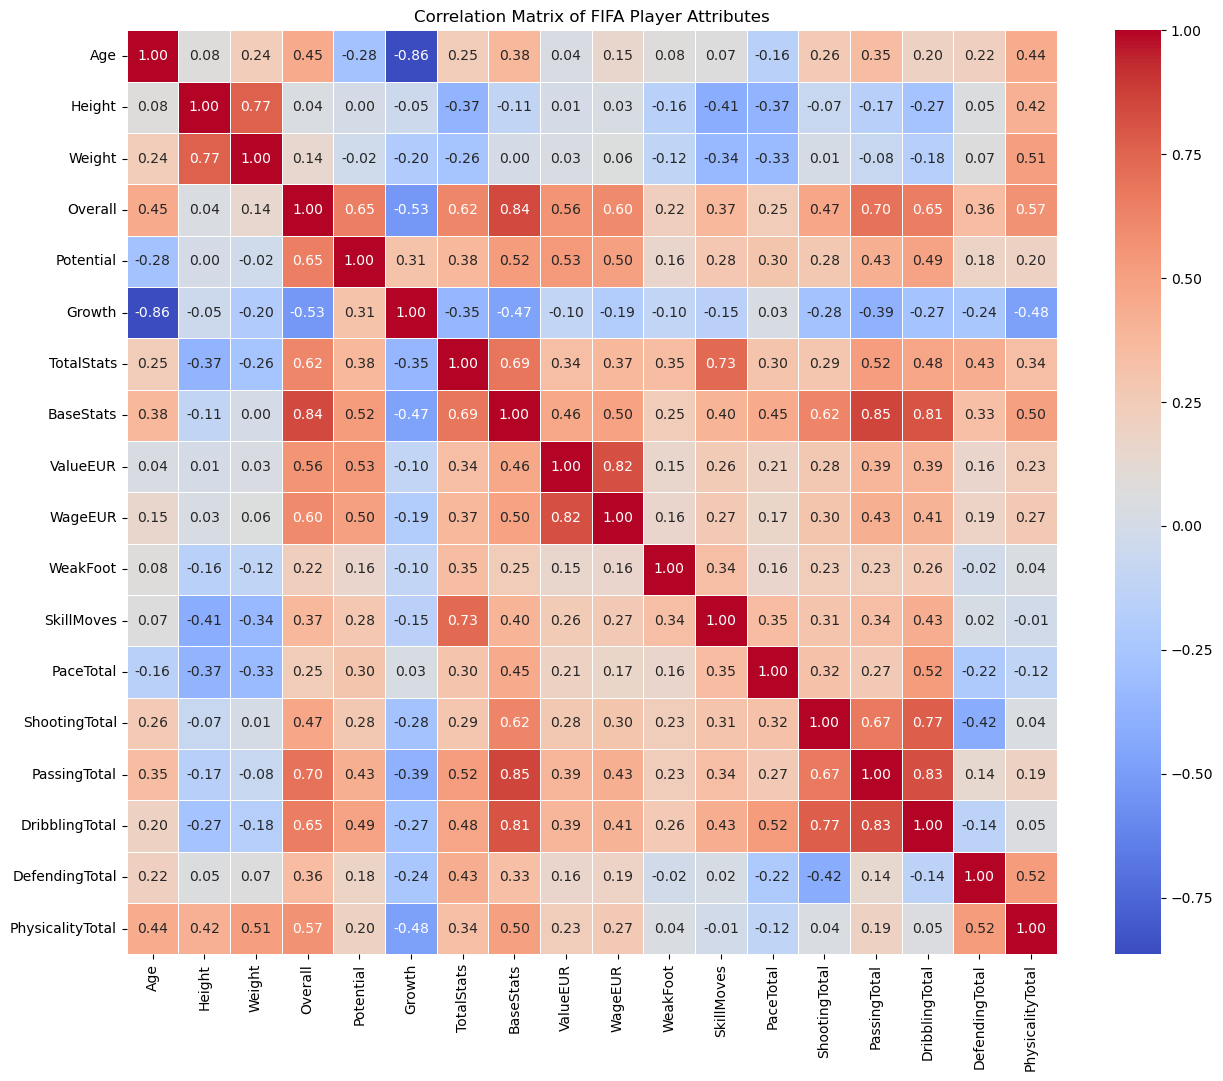

In [162]:
corr_matrix = df_main.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of FIFA Player Attributes')
plt.show()

<Axes: xlabel='Potential', ylabel='Growth'>

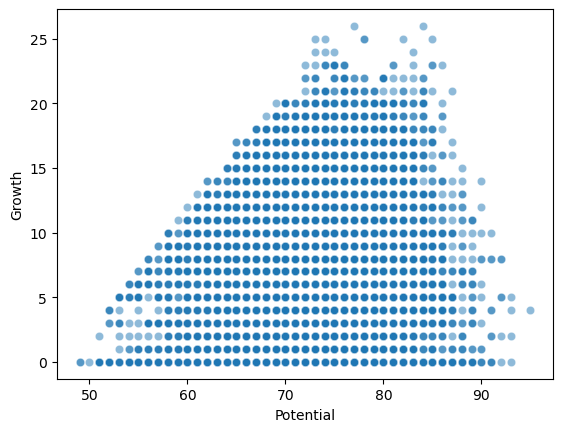

In [164]:
# sns.pairplot(df_main, diag_kind='kde', corner=True, markers='o', plot_kws={'alpha': 0.5})
# Which players have the highest growth potential and could represent high-value acquisitions for clubs looking to invest in future talent?
sns.scatterplot(x='Potential', y='Growth', data=df_main, alpha=0.5)
